# Test Battery for Clique Detection

I'm here:
1. Extact loops from the pair
1. Fix the ```1AB 2AB 3AB --> 123 AB``` problem

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
from functions_2020_01_25 import *

In [111]:
%config Application.log_level='INFO'

In [112]:
# Parameters
# METHOD_ID="2020-01-20 partial pairs"
# METHOD_ID="2020-01-24 all pairs"
METHOD_ID="2020-01-25 loop"
PAIRS_ID="all"

In [113]:
import sys
import logging
logging.basicConfig(format='%(funcName)s:%(levelname)s:%(message)s', level=logging.INFO, stream=sys.stdout)

## Tested examples

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['3', '2', '1']], 3.0: [['1', '2', '3'], ['C', 'B', 'A']], 6.0: [['2', 'A', 'B', 'C'], ['3', 'A', 'B', 'C'], ['1', 'A', 'B', 'C']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 2 times in this trace, loop: ['1', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['2', 'A', 'B', 'C']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['3', 'A', 'B', 'C']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', 'A', 'B', 'C']
infer_paths:INFO:Paths inferred (min_clique_size=3: {2.0: [['1', '2', '3']], 3.0: [['2', 'A', 'B', 'C'], ['3', 'A', 'B', 'C'], ['1', 'A', 'B', 'C']]})


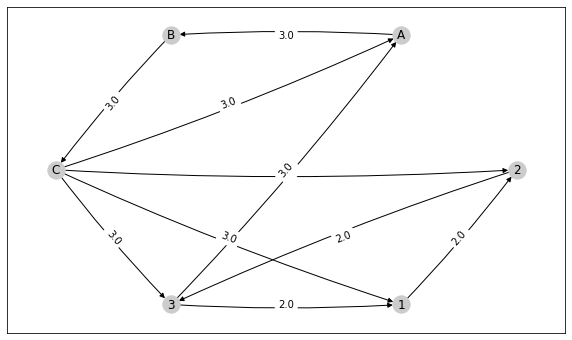



WARNING HERE! OJO AQUI!


Loops found:
{('1', '2', '3'): 2.0, ('A', 'B', 'C'): 3.0, ('2', 'A', 'B', 'C'): 3.0, ('3', 'A', 'B', 'C'): 3.0, ('1', 'A', 'B', 'C'): 3.0}

These 1 paths were correctly detected (1 undetected):
['2: 123']

These 3 paths are spurious:
['3: 2ABC', '3: 3ABC', '3: 1ABC']


In [114]:
# Type 76 ... Failing
T = [
    list("123123ABCABCABC")
#     list("ABCABCABC123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

## Single Trace Examples

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {10.0: [['A', 'B', 'C']], 6.0: [['C', 'B', 'A']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['A', 'B', 'C']
infer_paths:INFO:Paths inferred (min_clique_size=3: {4.0: [['A', 'B', 'C']]})


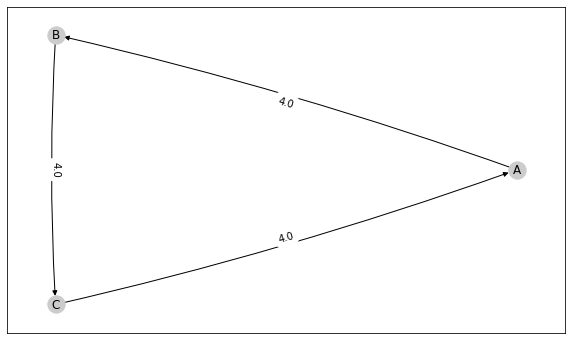

Loops found:
{('A', 'B', 'C'): 4.0}

These 1 paths were correctly detected (0 undetected):
['4: ABC']

These 0 paths are spurious:
[]


In [115]:
T = [
    list("ABCABCABCABC"),
]
g, b = evaluate_against(T, ["ABC"] )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['D', 'C', 'B', 'A']], 3.0: [['A', 'B', 'C', 'D']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 2 times in this trace, loop: ['A', 'B', 'C', 'D']
infer_paths:INFO:Paths inferred (min_clique_size=3: {2.0: [['A', 'B', 'C', 'D']]})


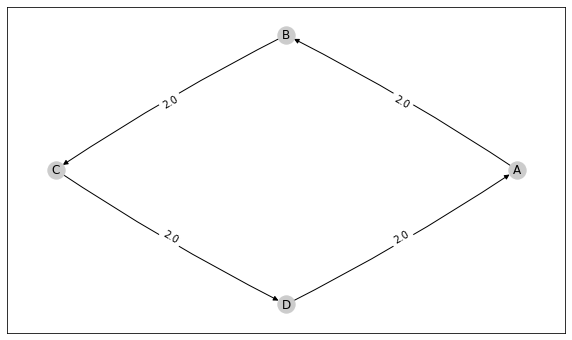

Loops found:
{('A', 'B', 'C', 'D'): 2.0}

These 1 paths were correctly detected (0 undetected):
['2: ABCD']

These 0 paths are spurious:
[]


In [116]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['1', '2', '3', '4', 'x', 'y', 'z'], ['D', 'C', 'B', 'A']], 3.0: [['A', 'B', 'C', 'D']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 2 times in this trace, loop: ['A', 'B', 'C', 'D']
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['1', '2', '3', '4', 'x', 'y', 'z']], 2.0: [['2', 'A', 'B', 'C', 'D'], ['4', 'A', 'B', 'C', 'D'], ['1', 'A', 'B', 'C', 'D'], ['A', 'B', 'C', 'D', 'z'], ['A', 'B', 'C', 'D', 'y'], ['A', 'B', 'C', 'D', 'x'], ['3', 'A', 'B', 'C', 'D']]})


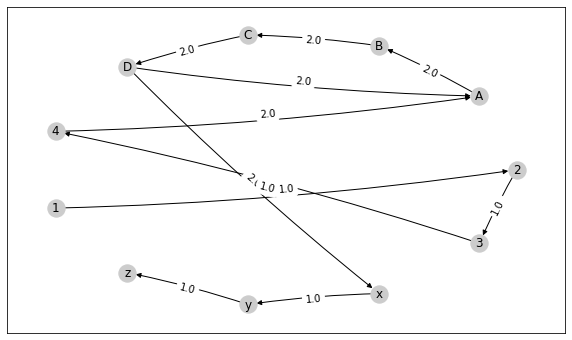



WARNING HERE! OJO AQUI!


Loops found:
{('A', 'B', 'C', 'D'): 2.0}

These 1 paths were correctly detected (1 undetected):
['1: 1234xyz']

These 7 paths are spurious:
['2: 2ABCD', '2: 4ABCD', '2: 1ABCD', '2: ABCDz', '2: ABCDy', '2: ABCDx', '2: 3ABCD']


In [117]:
T = [
    list("1234ABCDABCDxyz"),
]
g, b = evaluate_against(T, ["ABCD", "1234xyz"] )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['z', 'x', 'c', 'v']], 6.0: [['1', '2', '3'], ['A', 'B', 'C'], ['A', '2', '3'], ['A', 'B', '3']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', '3']
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['z', 'x', 'c', 'v']], 3.0: [['A', 'B', 'C', 'v'], ['A', 'B', 'C', 'z'], ['A', 'B', 'C', 'x'], ['A', 'B', 'C', 'c'], ['A', '2', '3', 'v'], ['A', '2', '3', 'z'], ['A', '2', '3', 'x'], ['A', '2', '3', 'c'], ['A', 'B', '3', 'v'], ['A', 'B', '3', 'z'], ['A', 'B', '3', 'x'], ['A', 'B',

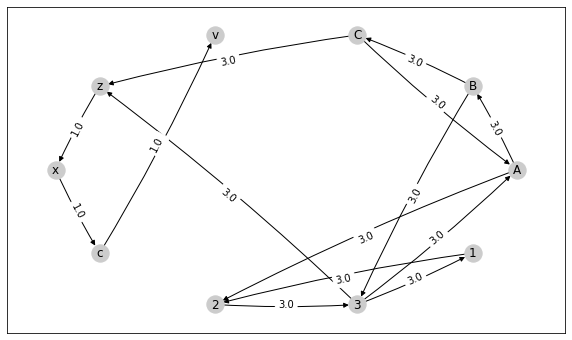



WARNING HERE! OJO AQUI!


Loops found:
{('1', '2', '3'): 3.0, ('A', 'B', 'C'): 3.0, ('A', '2', '3'): 3.0, ('A', 'B', '3'): 3.0}

These 1 paths were correctly detected (2 undetected):
['1: zxcv']

These 16 paths are spurious:
['3: ABCv', '3: ABCz', '3: ABCx', '3: ABCc', '3: A23v', '3: A23z', '3: A23x', '3: A23c', '3: AB3v', '3: AB3z', '3: AB3x', '3: AB3c', '3: 123v', '3: 123z', '3: 123x', '3: 123c']


In [118]:
# Type 75
T = [
    list("ABC1231A2B3C1ABC23zxcv"),
]
g, b = evaluate_against(T, ("ABC", "123", "zxcv") )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']], 6.0: [['A', '2', '3'], ['1', '2', '3'], ['A', 'B', '3'], ['1', 'B', '3'], ['A', 'B', 'C'], ['1', 'B', 'C']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', 'B', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', 

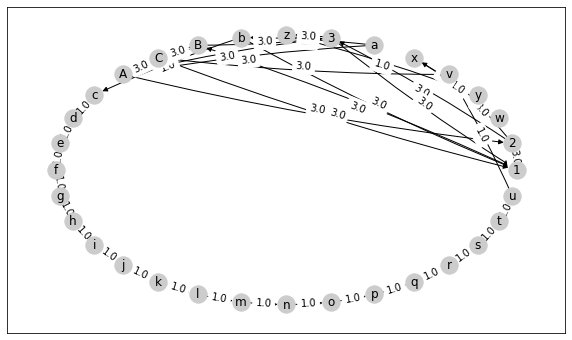



WARNING HERE! OJO AQUI!


Loops found:
{('A', '2', '3'): 3.0, ('1', '2', '3'): 3.0, ('A', 'B', '3'): 3.0, ('1', 'B', '3'): 3.0, ('A', 'B', 'C'): 3.0, ('1', 'B', 'C'): 3.0}

These 1 paths were correctly detected (2 undetected):
['1: abcdefghijklmnopqrstuvwxyz']

These 31 paths are spurious:
['3: 12w', '3: 12y', '3: 12v', '3: 12x', '3: a123', '3: 123z', '3: b123', '3: b1BC', '3: a1BC', '3: 1BCw', '3: 1BCz', '3: 1BCy', '3: 1BCv', '3: 1BCx', '3: a1B3', '3: 1B3z', '3: b1B3', '3: A2w', '3: A2y', '3: A2v', '3: A2x', '3: aA23', '3: A23z', '3: aABC', '3: ABCw', '3: ABCz', '3: ABCy', '3: ABCv', '3: ABCx', '3: aAB3', '3: AB3z']


In [119]:
# Type 77
T = [
    list("aAb1B2cd3Cefgh1iAjk2Blmnop3qCrst1AuBC2vwxy3z"),
]
g, b = evaluate_against(T, ("ABC", "123", "abcdefghijklmnopqrstuvwxyz") )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {3.0: [['3', '2', '1'], ['C', 'B', 'A']], 6.0: [['1', '2', '3'], ['A', 'B', 'C']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', '2', '3']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C']
infer_paths:INFO:Paths inferred (min_clique_size=3: {3.0: [['1', '2', '3'], ['A', 'B', 'C']]})


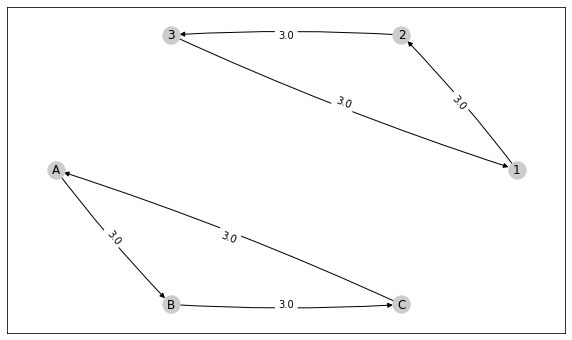

Loops found:
{('1', '2', '3'): 3.0, ('A', 'B', 'C'): 3.0}

These 2 paths were correctly detected (0 undetected):
['3: 123', '3: ABC']

These 0 paths are spurious:
[]


In [120]:
# Type 78
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.123")
]
g, b = evaluate_against(T, ("ABC", "123") )

get_successor_by_freq:INFO:Using PAIRS_ID all
get_successor_pairs:INFO:Using PAIRS_ID all
infer_paths:INFO:Paths inferred (min_clique_size=3: {1.0: [['1', '2', '3']], 6.0: [['g', 'f', 'e'], ['A', 'B', 'C', 'D']], 10.0: [['B', 'e', 'f', 'g'], ['C', 'e', 'f', 'g'], ['A', 'e', 'f', 'g'], ['D', 'e', 'f', 'g']]})
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['e', 'f', 'g']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C', 'D']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['B', 'e', 'f', 'g']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['C', 'e', 'f', 'g']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['A', 'e', 'f', 'g']
remove_loops_in_trace:INFO:Loop candidate FOUND: repeated 4 times in this trace, loop: ['D', 'e', 'f', 'g']
infer_paths:INFO:Paths inferred (min_clique_siz

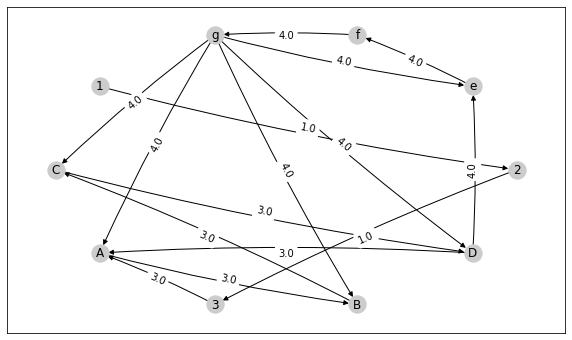



WARNING HERE! OJO AQUI!


Loops found:
{('e', 'f', 'g'): 4.0, ('A', 'B', 'C', 'D'): 3.0, ('B', 'e', 'f', 'g'): 4.0, ('C', 'e', 'f', 'g'): 4.0, ('A', 'e', 'f', 'g'): 4.0, ('D', 'e', 'f', 'g'): 4.0}

These 1 paths were correctly detected (2 undetected):
['1: 123']

These 10 paths are spurious:
['3: 2ABCD', '3: 3ABCD', '3: 1ABCD', '4: 2efg', '4: 1efg', '4: Cefg', '4: Aefg', '4: 3efg', '4: Befg', '4: Defg']


In [121]:
"""
head_with_loop = 123 ABCD* efg*

12 @ABCD @ef
"""
T = [
    list("123ABCDefgABCDABCDefgefgefg"),
]
g, b = evaluate_against(T, ("ABCD", "123", "efg") )

## Multiple Trace Examples

In [ ]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

In [ ]:
# Type 76-b
T = [
    list("ABCABCABC"),
    list("123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

Claim: all paths (cliques) forming a base are loops. Starting from max(f) -> min(f).

### Examples from previous notebooks

In [ ]:
# combined_loops: lk 12 ABCDE
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ("ABCDE", "lk", "12") )

In [ ]:
"""
  @lk - @12 - @ABCDE
"""
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ["ABCDE", "lk", "12"] )

In [ ]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
g, b = evaluate_against(T, ("ABC", "123") )

## Still Failing. Still...

In [ ]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )

In [ ]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )

In [ ]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345FG", "hjk", "def", "xyz"] )

In [ ]:
tree_trace = [
    list("ABmn12"),
    list("ABmn56"),
    list("ABpq12"),
    list("ABpq56"),
    list("ABst12"),
    list("ABst56"),
]
# inferred_paths = clique_discovery.infer_paths_from_traces( tree_trace )
# untangled_graph( clique_discovery.minimally_connected_graph( inferred_paths ) , with_weigths=False )
g, b = evaluate_against(tree_trace, ["AB", "mn", "12", "pq", "st", "56"] )